In [2]:
import numpy as np
import pandas as pd

import pandas_datareader.data as web

from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.utils.plotting import plot_series
from sktime.split import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsoluteError
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.base import ForecastingHorizon

from Subspace import StateSpaceModel

# настройки визуализация
import matplotlib.pyplot as plt

# Не показывать Warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)
# Не показывать ValueWarning, ConvergenceWarning из statsmodels
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
warnings.simplefilter('ignore', category=ValueWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)

In [3]:
# 'WGS10YR', 'DGS10'
y = np.log(web.DataReader(name='WM2NS', data_source='fred',start='2010-01-01', end='2023-12-31').dropna() )

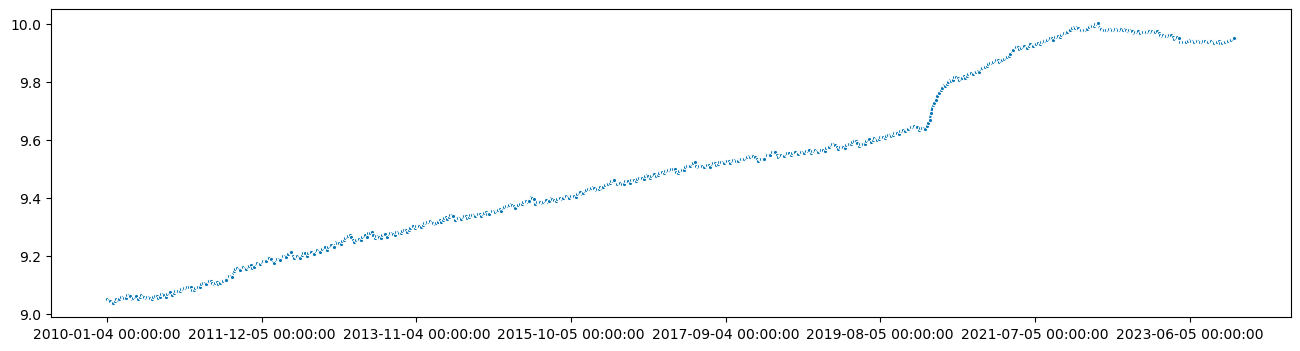

In [4]:
plot_series(y, markers=['.'])

plt.show()

In [5]:
# разбиваем выбору на обучающую (первые 80%) и тестовую
y_train, y_test = temporal_train_test_split(y, train_size=0.8)

In [17]:
ssm = StateSpaceModel(3)

ssm.fit(y_train)

y_pred = ssm.predict(y_test.shape[0])

y_pred_ssm = pd.DataFrame(y_pred, index=y_test.index) 

# инициализируем метрику
mse = MeanSquaredError(square_root=False)
# вычисляем метрику на данных
mse.evaluate(y_test, y_pred)

0.013690040455161295

In [7]:
# специфицируем модель
forecaster = AutoARIMA(max_p=8, max_q=8, test='kpss', information_criterion='bic')

forecaster.fit(y_train)

# прогнозируем для тестовых наблюдений
y_pred_arima = forecaster.predict(fh =  ForecastingHorizon(y_test.index, is_relative=False, freq='W-Mon') )

# инициализируем метрику
mse = MeanSquaredError(square_root=False)
# вычисляем метрику на данных
mse.evaluate(y_test, y_pred_arima)

0.0055453783036295895

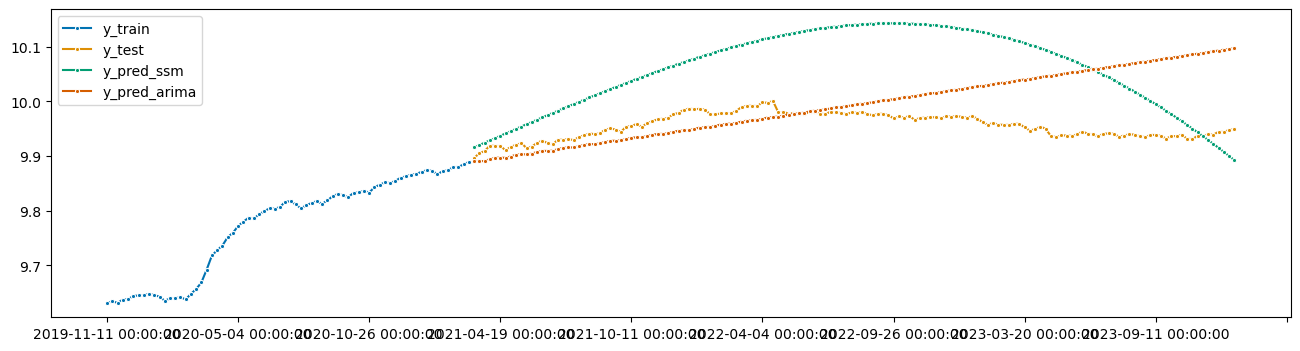

In [19]:
plot_series(y_train.tail(70), y_test, y_pred_ssm, y_pred_arima, labels=['y_train', 'y_test', 'y_pred_ssm', 'y_pred_arima'], markers=['.', '.', '.', '.'])

plt.show()

In [9]:
forecaster.get_fitted_params()

{'intercept': 0.0024600102417382743,
 'ar.L1': 0.24150412870434776,
 'ar.L2': -0.9581801437766717,
 'ma.L1': -0.15019748206038158,
 'ma.L2': 0.830591449268402,
 'sigma2': 1.893802387591265e-05,
 'order': (2, 1, 2),
 'seasonal_order': (0, 0, 0, 0),
 'aic': -4670.882270693375,
 'aicc': -4670.736437360042,
 'bic': -4644.673147575272,
 'hqic': -4660.666492577957}